In [1]:
import os
import numpy as np
import glob
import pandas as pd  
import random
import math as mp
import pickle
#import matplotlib.pyplot as plt
import tensorflow as tf
import time
from pickle import load
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from pyquaternion import Quaternion
%matplotlib inline
#import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow.keras.backend as K
from numpy import array
from numpy import hstack
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Conv1D, Input, Lambda, GRU
from tensorflow.compat.v1.keras.layers import CuDNNLSTM, CuDNNGRU
from tensorflow.keras.layers import Dense,Flatten,Dropout, MaxPooling1D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import GlobalMaxPooling1D, AveragePooling1D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras import backend as K
from tensorflow.python.keras.engine import data_adapter

import toml
from math import floor
from ipynb.fs.full.V07_Utils  import *
from ipynb.fs.full.V07_Prepare_dataset import *

In [2]:
######################################################################
# Init Configuration
######################################################################

config_path = 'C:/Users/Thomas Weikert/Documents/Thesis/Project_V07_24092021/Code/V07_config.toml'
cfg = toml.load(config_path)

# General 
n_in_seq = cfg['n_in_seq_quat_gaze']
n_out_seq = cfg['n_out_seq_quat']
n_steps = cfg['n_steps'] 
LAT_in_rows = cfg['LAT_in_rows'] #6*16,66ms= 64ms

# model ID --> specify this for every new model
model_id = cfg['6_1_model_ID']
model_type = cfg['6_model_type']

# Directories 
Path_dataset01_test = cfg['Path_dataset01']
Path_results_dataset01_GRU_quat_model_id = cfg['Path_results_dataset01'] + model_type + "/" + model_id  + "/" 

# Tensorflow configuration
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)
print("Num GPUs Available: ", len(tf.config.list_physical_devices("GPU")))

Num GPUs Available:  0


In [3]:
def conjugate(q):
    mult = tf.constant(np.array([1,-1,-1,-1])[np.newaxis], dtype=np.float32)
    return q*mult

def inverse(q):
    return conjugate(q) / tf.reduce_sum(q*q, axis=-1, keepdims=True)

def log(q):
    v = q[:, 1:]
    a = q[:, :1]
    q_norm = tf.norm(q, axis=-1, keepdims=True)
    x = a / q_norm
    eps = np.finfo(np.float32).eps * 8.0
    x *= (1.0 - eps)
    vec_part = tf.nn.l2_normalize(v, axis=-1) * tf.math.acos(x)
    real_part = tf.math.log(q_norm)
    return tf.concat([real_part, vec_part], axis=-1)

def mult(quaternion1, quaternion2):
    w1, x1, y1, z1 = tf.unstack(quaternion1, axis=-1)
    w2, x2, y2, z2 = tf.unstack(quaternion2, axis=-1)
    x = x1 * w2 + y1 * z2 - z1 * y2 + w1 * x2
    y = -x1 * z2 + y1 * w2 + z1 * x2 + w1 * y2
    z = x1 * y2 - y1 * x2 + z1 * w2 + w1 * z2
    w = -x1 * x2 - y1 * y2 - z1 * z2 + w1 * w2
    return tf.stack((w, x, y, z), axis=-1)
    
def geodesic_dist(q1, q2):
    #q1 = q1/tf.norm(q1)
    #q2 = q2/tf.norm(q2)
    #q2  = K.print_tensor(q2, message='q2  = ')
    #q1  = K.print_tensor(q1, message='q1  = ')
    #q1_printer = tf.strings.as_string(q1)
    #q2_printer = tf.strings.as_string(q2)
    #tf.io.write_file(Path_results_dataset01_GRU_quat_model_id + individual_name + "_q1_Tensors.csv", str(q1_printer), name=None)
    #tf.io.write_file(Path_results_dataset01_GRU_quat_model_id + individual_name + "_q2_Tensors.csv", str(q2_printer), name=None)

    x = mult(inverse(q1), q2)
    x = tf.norm(log(x), axis=-1)
    return x


def angle_dist(q1, q2):
    x = tf.reduce_sum(q1*q2, axis=-1)
    eps = np.finfo(np.float32).eps * 8.0
    x *= (1.0 - eps)
    x = 2*tf.math.acos(x)
    return tf.reduce_mean(x)


def quat_antipodal_loss(y_true, y_pred):
    dist1 = tf.reduce_mean(tf.abs(y_true-y_pred), axis=-1)
    dist2 = tf.reduce_mean(tf.abs(y_true+y_pred), axis=-1)
    loss = tf.where(dist1<dist2, dist1, dist2)
    return tf.reduce_mean(loss)


def euler_angles_loss(y_true, y_pred):
    dist1 = tf.abs(y_true - y_pred)
    dist2 = tf.abs(2*np.pi + y_true - y_pred)
    dist3 = tf.abs(-2*np.pi + y_true - y_pred)
    loss = tf.where(dist1<dist2, dist1, dist2)
    loss = tf.where(loss<dist3, loss, dist3)
    return tf.reduce_mean(loss)


def mean_angle_btw_vectors(v1, v2):
    dot_product = tf.reduce_sum(v1*v2, axis=-1)
    cos_a = dot_product / (tf.norm(v1, axis=-1) * tf.norm(v2, axis=-1))
    eps = 1e-8
    cos_a = tf.clip_by_value(cos_a, -1 + eps, 1 - eps)
    angle_dist = tf.math.acos(cos_a) / np.pi * 180.0
    return tf.reduce_mean(angle_dist)

def minmax_inverse_transform(y_true, y_pred):
    
    w_min, x_min, y_min, z_min, w_max, x_max, y_max, z_max = 0,0,0,0,1,1,1,1
    
    w1, x1, y1, z1 = tf.unstack(y_true, axis=-1)
    w2, x2, y2, z2 = tf.unstack(y_pred, axis=-1)
    
    w1, w2 = (w1 - K.constant(w_min)) / K.constant(w_max - w_min) , (w2 - K.constant(w_min)) / K.constant(w_max - w_min)
    x1, x2 = (x1 - K.constant(x_min)) / K.constant(x_max - x_min) , (x2 - K.constant(x_min)) / K.constant(x_max - x_min)
    y1, y2 = (y1 - K.constant(y_min)) / K.constant(y_max - y_min) , (y2 - K.constant(y_min)) / K.constant(y_max - y_min)
    z1, z2 = (z1 - K.constant(z_min)) / K.constant(z_max - z_min) , (z2 - K.constant(z_min)) / K.constant(z_max - z_min)

    y_true = tf.stack((w1, x1, y1, z1), axis=-1)
    y_pred = tf.stack((w2, x2, y2, z2), axis=-1)
    return y_true, y_pred

def ang_mae(y_true,y_pred):
    ang_dist = geodesic_dist(y_true, y_pred) #returns a value between 0 and pi
    #ang_dist_deg = rad2deg(ang_dist_rad)
    shape = tf.cast(tf.size(ang_dist),dtype=np.float32)
    ang_mae =  K.sum(ang_dist)/shape
    #y_pred  = K.print_tensor(y_pred, message='y_pred  = ')
    #y_true  = K.print_tensor(y_true, message='y_true  = ')
    return tf.reduce_mean(ang_mae)

def rad2deg(rad):
    pi_on_180 = 0.017453292519943295
    return rad / pi_on_180


def absolute_distance(q0, q1):
    q0_minus_q1 = q0 - q1
    q0_plus_q1  = q0 + q1
    d_minus =  tf.norm(q0_minus_q1, axis=-1, keepdims=True) 
    d_plus  = tf.norm(q0_plus_q1, axis=-1, keepdims=True) 
    check = tf.math.less(d_minus, d_plus)
    result = tf.where(check == True , d_minus, d_plus)
    q0  = K.print_tensor(q0, message='q0  = ')
    q1  = K.print_tensor(q1, message='q1  = ')
    return tf.reduce_mean(result)


def rotation_loss(y_true, y_pred):
    #q1 = q1/tf.norm(q1)
    #q2 = q2/tf.norm(q2)
    #y_pred  = K.print_tensor(y_pred, message='y_pred  = ')
    #y_true  = K.print_tensor(y_true, message='y_true  = ')
    #y_pred = y_pred/tf.norm(y_pred)
    #y_true = y_true/tf.norm(y_true)
    loss = y_true - y_pred
    loss = tf.norm(loss)
    return tf.reduce_mean(loss)


def rotation_loss_2(y_true,y_pred):
    rotation_loss = tf.sqrt(tf.nn.l2_loss(y_true-y_pred))
    return tf.reduce_mean(rotation_loss)



In [22]:
def euclidean_distance_loss(y_true, y_pred):
    """
    Euclidean distance loss
    https://en.wikipedia.org/wiki/Euclidean_distance
    :param y_true: TensorFlow/Theano tensor
    :param y_pred: TensorFlow/Theano tensor of the same shape as y_true
    :return: float
    """
    return K.sqrt(K.sum(K.square(y_pred - y_true), axis=-1))
  

In [25]:
def GRU_v01(X_train, y_train, Neurons, Dropout_rate,Learning_rate, Decay):

    # the dataset knows the number of features, e.g. 2
    n_steps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]

    # define model
    model = Sequential()
    model.add(GRU(Neurons, input_shape=(n_steps, n_features),return_state=False , return_sequences=True))    
    model.add(GRU(Neurons,return_state=False , return_sequences=False))    
    model.add(Flatten())
    model.add(Dense(4))
    
    #opt = tf.keras.optimizers.Adamax(learning_rate=0.005, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name="Adamax")
    #opt = tf.keras.optimizers.SGD(lr=0.01, momentum=0.5, decay=0.001)
    opt = tf.keras.optimizers.Adam(learning_rate=Learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=Decay)    
    
    model.compile(opt, loss=geodesic_dist) #run_eagerly=True
    #model.train_step = make_print_data_and_train_step(model)
    model.summary()
        
    return model

In [26]:
def Baseline(X_train, y_train):

    # the dataset knows the number of features, e.g. 2
    n_steps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]
    
    # Slice over each sequence and receive the last input
    # call groundtruth 
    # call evaluation metrics from 
    
    input_lyr = Input(shape=(n_steps, n_features), dtype=tf.float32)
    sliced_lyr = Lambda(lambda X_train: X_train[:,-1,:])
    baseline = Sequential([input_lyr,sliced_lyr,])
    baseline.compile(loss=geodesic_dist) #run_eagerly=True
    
    #baseline.train_step = make_print_data_and_train_step(baseline)
    
    return baseline

In [27]:
def save_model(model, path):
# serialize model to YAML
    model_yaml = model.to_yaml()
    with open(path +  "_CUDNN_arch.yaml", "w") as yaml_file:
        yaml_file.write(model_yaml)
    model.save_weights(path + "_CUDNN_best_model.h5")
    return print("Saved model to disk")

In [28]:
def reset_random_seeds():
   os.environ['PYTHONHASHSEED']=str(2)
   tf.random.set_seed(2)
   np.random.seed(2)
   random.seed(2)

# Train the mdel 

In [29]:
y_true_list = []
y_pred_list = []


def make_print_data_and_train_step(keras_model):
        original_train_step = keras_model.train_step

        def print_data_and_train_step(original_data):
            # Basically copied one-to-one from https://git.io/JvDTv
            data = data_adapter.expand_1d(original_data)
            x, y_true, w = data_adapter.unpack_x_y_sample_weight(data)
            y_pred = keras_model(x, training=True)

            # this is pretty much like on_train_batch_begin
            #K.print_tensor(w, "Sample weight (w) =")
            #K.print_tensor(x, "Batch input (x) =")
            #K.print_tensor(y_true, "Batch output (y_true) =")
            #K.print_tensor(y_pred, "Prediction (y_pred) =")

            result = original_train_step(original_data)     


            # add anything here for on_train_batch_end-like behavior

            y_true_np = y_true.numpy()
            y_true_list.append(y_true_np)
            

            y_pred_np = y_pred.numpy()
            y_pred_list.append(y_pred_np)
           
            y_true_df = pd.DataFrame(np.row_stack(y_true_list), columns= cfg['quat_coords_true'])
            y_true_df.to_csv(os.path.join(Path_results_dataset01_GRU_quat_model_id + 'y_true.csv'), index=False)

            y_pred_df = pd.DataFrame(np.row_stack(y_pred_list), columns= cfg['quat_coords_pred'])
            y_pred_df.to_csv(os.path.join(Path_results_dataset01_GRU_quat_model_id + 'y_pred.csv'), index=False)


            return result

        return print_data_and_train_step

In [30]:
class CustomCallback(keras.callbacks.Callback):
    
    
    def on_train_batch_end(self, batch, logs=None):
        print("For batch {}, loss is {:7.4f}.".format(batch, logs["loss"]))

    def on_test_batch_end(self, batch, logs=None):
        print("For batch {}, loss is {:7.4f}.".format(batch, logs["loss"]))

    def on_epoch_end(self, epoch, logs=None):
        print("The average loss for epoch {} is {:7.4f} ".format(epoch, logs["loss"]))

In [31]:
#LAT_in_rows = [1,2,3,4,5,6,7,8,9,10]
Neurons = [32]
Dropout_rate = [0.5]
Learning_rate = [0.01]
Batch_size = [128]
Epochs = [20]
Decay = [0.01]

------------- GRU_v01 --------------------
24490
24489
X shape is: (24460, 30, 4)
y shape is: (24460, 4)
------
10490
10489
X shape is: (10460, 30, 4)
y shape is: (10460, 4)
------
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_2 (GRU)                  (None, 30, 32)            3648      
_________________________________________________________________
gru_3 (GRU)                  (None, 32)                6336      
_________________________________________________________________
flatten_1 (Flatten)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 132       
Total params: 10,116
Trainable params: 10,116
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
192/192 [==============================] - 7s 38ms/step 

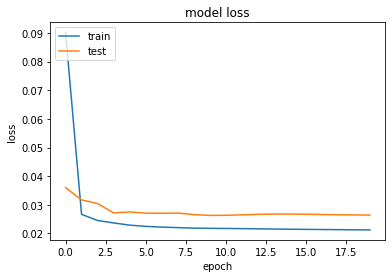

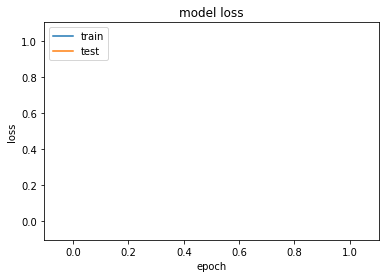

In [32]:
for Neurons_i in Neurons:
    for Dropout_rate_i in Dropout_rate:
        for Learning_rate_i in Learning_rate:
            for Batch_size_i in Batch_size:
                for Epochs_i in Epochs:
                    for Decay_i in Decay:
                    
                        reset_random_seeds()
                    
                        
                        #### GRU_v01 #######################################
                        print("------------- GRU_v01 --------------------")
                        
                        ########### GRU Delta ####################
                        X_train, X_val, y_train, y_val = prepare_training_data_quat_delta(Path_dataset01_test)
                        ############################################
                        
                        
                        ########### GRU Absolut ####################
                        #X_train, X_val, y_train, y_val = prepare_training_data_quat(Path_dataset01_test)
                        ############################################
                        
                        
                        model = GRU_v01(X_train, y_train, Neurons_i, Dropout_rate_i,Learning_rate_i, Decay_i)
                        
                        
                        individual_name = "Delta_Gaze_GRU_v01_Neurons_" + str(Neurons_i) + "_" + "_DR_" + str(Dropout_rate_i) + "__" + "LR_" + str(Learning_rate_i) + "__" + "Batch_" + str(Batch_size_i) + "__" + "Epochs_" + str(Epochs_i) 
                        
                        # callbacks parameter
                        #es = EarlyStopping(monitor='val_loss', mode='min', patience=10)
                        #mc = ModelCheckpoint(Path_results_dataset01_GRU_quat_model_id + "/Model/" + individual_name +  '_CUDNN_best_model.h5', monitor ='val_loss', mode='min', save_best_only=True, verbose=0)
                        #csv_logger = CSVLogger(Path_results_dataset01_GRU_quat_model_id + "/Model/" + individual_name + '.csv', append=True, separator=';')
                        
                        # validation_data=(X_val, y_val)
                        history = model.fit(X_train, y_train, validation_data=(X_val, y_val), shuffle = False, batch_size=Batch_size_i, epochs=Epochs_i, verbose=1) #callbacks=[es,mc,csv_logger] , callbacks=[CustomCallback()]
                        #val_history = model.evaluate(X_val, y_val, batch_size=1, verbose=1) #callbacks=[es,mc,csv_logger]

                        save_model(model,Path_results_dataset01_GRU_quat_model_id + "/Model/" + individual_name )
                        
                        
                        loss_history = history.history["loss"]
                        plt.plot(history.history['loss'])
                        plt.plot(history.history['val_loss'])
                        plt.title('model loss')
                        plt.ylabel('loss')
                        plt.xlabel('epoch')
                        plt.legend(['train', 'test'], loc='upper left')
                        plt.show()
                        
                        loss_history = np.array(history.history["loss"]) 
                        df_loss = pd.DataFrame(loss_history)
                        df_loss = df_loss[df_loss > 0.2]
                        df_loss = df_loss[df_loss < 0.2]
                        
                        val_loss_history = np.array(history.history["val_loss"]) 
                        df_val_loss = pd.DataFrame(val_loss_history)
                        df_val_loss = df_val_loss[df_loss > 0.2]
                        df_val_loss = df_val_loss[df_loss < 0.2]

                
                        plt.plot(df_loss)
                        plt.plot(df_val_loss)
                        plt.title('model loss')
                        plt.ylabel('loss')
                        plt.xlabel('epoch')
                        plt.legend(['train', 'test'], loc='upper left')
                        plt.show()
                        
                        
                        
                        tf.keras.backend.clear_session()
                        

In [19]:
for csv in get_csv_files(Path_dataset01_test, "full*cont"):
    print(csv)

    
    ########### GRU Delta ####################
    #X_test, y_test = prepare_testing_data_quat_special_delta(csv)
    ############################################


    ########### GRU Absolut ####################
    X_test, y_test = prepare_testing_data_quat_special(csv)
    ############################################
    
    
    
    model.evaluate(X_test, y_test, batch_size=128, verbose=1) #callbacks=[es,mc,csv_logger]
    print("--------")

C:/Users/Thomas Weikert/Documents/Thesis/Project_V07_24092021/Data/01_Dataset\1_full_continious.csv
34990
34989
X shape is: (34960, 30, 4)
y shape is: (34960, 4)
------
274/274 [==============================] - 2s 9ms/step - loss: 0.0048
--------
C:/Users/Thomas Weikert/Documents/Thesis/Project_V07_24092021/Data/01_Dataset\2_full_continious.csv
14990
14989
X shape is: (14960, 30, 4)
y shape is: (14960, 4)
------
117/117 [==============================] - 1s 9ms/step - loss: 0.0045
--------
C:/Users/Thomas Weikert/Documents/Thesis/Project_V07_24092021/Data/01_Dataset\3_full_continious.csv
44990
44989
X shape is: (44960, 30, 4)
y shape is: (44960, 4)
------
352/352 [==============================] - 3s 9ms/step - loss: 0.0046
--------
C:/Users/Thomas Weikert/Documents/Thesis/Project_V07_24092021/Data/01_Dataset\4_full_continious.csv
69990
69989
X shape is: (69960, 30, 4)
y shape is: (69960, 4)
------
547/547 [==============================] - 5s 9ms/step - loss: 0.0048
--------
C:/Users

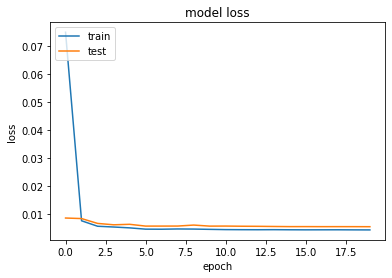

In [20]:
loss_history = np.array(history.history["loss"]) 
df_loss = pd.DataFrame(loss_history)
df_loss = df_loss[df_loss < 0.2]

val_loss_history = np.array(history.history["val_loss"]) 
df_val_loss = pd.DataFrame(val_loss_history)
df_val_loss = df_val_loss[df_val_loss < 0.2]


plt.plot(df_loss)
plt.plot(df_val_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# BASELINE

In [21]:
#LAT_in_rows = [1,2,3,4,5,6,7,8,9,10]
Neurons = [32]
Batch_size = [256]
Epochs = [1]

tf.random.set_seed(0)

In [22]:
for Neurons_i in Neurons:
    for Dropout_rate_i in Dropout_rate:
        for Learning_rate_i in Learning_rate:
            for Batch_size_i in Batch_size:
                for Epochs_i in Epochs:
                    for Decay_i in Decay:
                        for csv in get_csv_files(Path_dataset01_test, "full*cont"):
                            print(csv)

                            tf.random.set_seed(0)


                            ########### BAseline ####################
                            X_Baseline, y_Baseline = prepare_testing_data_quat_special(csv)
                            ############################################


                            #### Baseline #######################################
                            print("------------- Baseline --------------------")


                            baseline = Baseline(X_Baseline, y_Baseline)

                            baseline_history = baseline.fit(X_Baseline, y_Baseline, shuffle = False, batch_size=Batch_size_i, epochs=Epochs_i, verbose=1) #callbacks=[es,mc,csv_logger] , callbacks=[CustomCallback()]

                            tf.keras.backend.clear_session()

                            print("------------------------------------------")
                        

C:/Users/Thomas Weikert/Documents/Thesis/Project_V07_24092021/Data/01_Dataset\1_full_continious.csv
34990
34989
X shape is: (34960, 30, 4)
y shape is: (34960, 4)
------
------------- Baseline --------------------
137/137 [==============================] - 0s 1ms/step - loss: 0.0255
------------------------------------------
C:/Users/Thomas Weikert/Documents/Thesis/Project_V07_24092021/Data/01_Dataset\2_full_continious.csv
14990
14989
X shape is: (14960, 30, 4)
y shape is: (14960, 4)
------
------------- Baseline --------------------
59/59 [==============================] - 0s 1ms/step - loss: 0.0231
------------------------------------------
C:/Users/Thomas Weikert/Documents/Thesis/Project_V07_24092021/Data/01_Dataset\3_full_continious.csv
44990
44989
X shape is: (44960, 30, 4)
y shape is: (44960, 4)
------
------------- Baseline --------------------
176/176 [==============================] - 0s 1000us/step - loss: 0.0287
------------------------------------------
C:/Users/Thomas Weike